In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_7_descriptive = get_prompt("descriptive", 7)
prompt_7_natural = get_prompt("natural", 7)

prompt_7_descriptive, prompt_7_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1 ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area).',
 'Simulate 1LYZ for 1 ps at 300 K. Report the secondary structure assignments of the PDB structure and any known binding or active sites. Compute the RMSD, SASA, and radius of gyration of the simulation.')

Required Tasks:
- Download
- SS Analysis
- Simulation
- RMSD
- Rgy
- SASA
- Binding/Active Sites

In [3]:
llm_model = "claude-3-5-sonnet-20240620"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_1.run(prompt_7_descriptive)

Thought: To complete all the tasks, I'll need to use multiple tools in sequence. Let's start with downloading the PDB file 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we've successfully downloaded the PDB file for 1LYZ. Now, let's move on to the next task, which is to report the secondary structure assignments of the PDB structure.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_181039",
        "top_file": "1LYZ_181039",
        "target_frames": "first"
    }
}
```Thought: We've successfully obtained the secondary structure assignments for 1LYZ. Now, let's move on to finding any known binding or active sites. For this, we'll need to use the UniProt database, so first we need to get the UniProt ID for 1LYZ.

Action:
```
{
    "action": "MapProteinRepresentation",
    "action_input": {
        "query": "1LYZ",
        "src_db": "PDB",
        "dst_db

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_181039: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_181039
 rec0_181042: dssp values for trajectory with id: 1LYZ_181039
 rec0_181114: dssp values for trajectory with id: 1LYZ_181039
 1LYZ_181233: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_181256: Initial positions for simulation sim0_181256
 sim0_181256: Basic Simulation of Protein 1LYZ_181233
 rec0_181256: Simulation trajectory for protein 1LYZ_181233 and simulation sim0_181256
 rec1_181256: Simulation state log for protein 1LYZ_181233 and simulation sim0_181256
 rec2_181256: Simulation pdb frames for protein 1LYZ_181233 and simulation sim0_181256
 rmsd_Lysozyme C: RMSD for Lysozyme C
 fig0_181351: RMSD plot for Lysozyme C
 rgy_rec0_181256: Radii of gyration per frame for rec0_181256
 fig0_181413: Plot of radii of gyration over time for rec0_181256
 sasa_Lysozyme C: 

In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_181039"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_181039", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [9]:
# make sure trajectory and topology exist
traj_path_1 = registry_1.get_mapped_path("rec0_181256")
top_path_1 = registry_1.get_mapped_path("top_sim0_181256")

assert os.path.exists(traj_path_1)
assert os.path.exists(top_path_1)

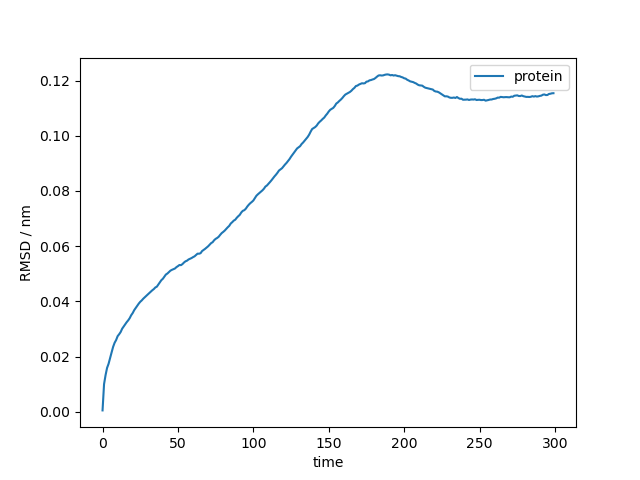

In [10]:
# make sure rmsd plot was generated
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_181351'))

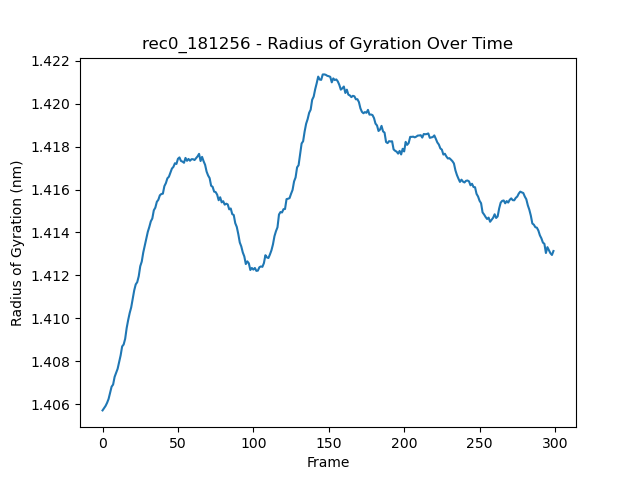

In [11]:
# make sure rgy plot was generated
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_181413'))

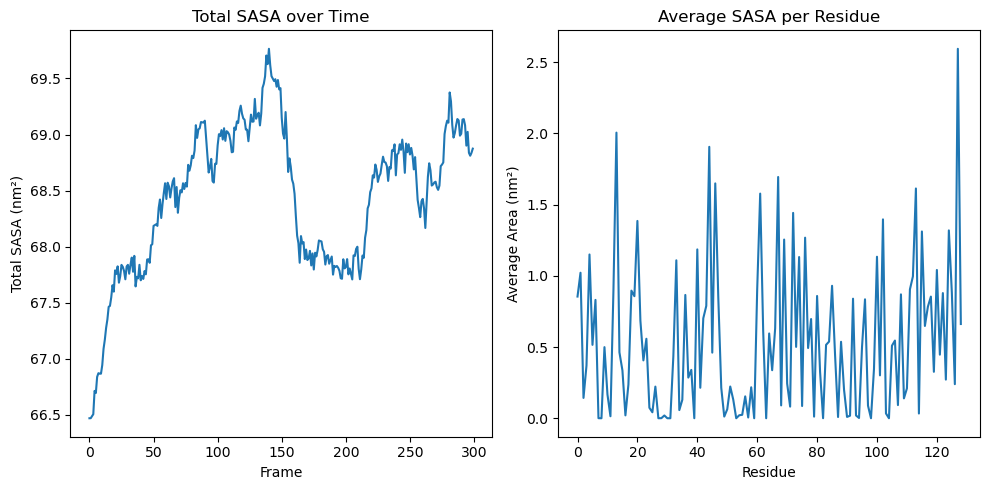

In [12]:
# make sure sasa plot was generated
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_181512'))

In [13]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_2.run(prompt_7_natural)

Thought: To address this question, we need to follow several steps. First, we'll download the PDB file for 1LYZ, then set up and run a simulation. After that, we'll analyze the results and gather additional information about the protein's structure and sites. Let's start by downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we have successfully downloaded the PDB file for 1LYZ. Now, let's set up and run a short simulation for 1 ps at 300 K using the SetUpandRunFunction tool.

Action:
```
{
    "action": "SetUpandRunFunction",
    "action_input": {
        "pdb_id": "1LYZ_182000",
        "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
        "system_params": {
            "nonbondedMethod": "PME",
            "nonbondedCutoff": "1 * nanometers",
            "constraints": "HBonds",
            "rigidWater": true,
            "ewaldErrorTolerance": 0.0005,
        

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [14]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_182000: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_182000
 1LYZ_182011: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_182016: Initial positions for simulation sim0_182016
 sim0_182016: Basic Simulation of Protein 1LYZ_182011
 rec0_182020: Simulation trajectory for protein 1LYZ_182011 and simulation sim0_182016
 rec1_182020: Simulation state log for protein 1LYZ_182011 and simulation sim0_182016
 rec2_182020: Simulation pdb frames for protein 1LYZ_182011 and simulation sim0_182016
 rec0_182855: dssp values for trajectory with id: rec2_182020
 1LYZ_182954: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_183018: Initial positions for simulation sim0_183018
 sim0_183018: Basic Simulation of Prote

In [16]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_182000"))

In [19]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [20]:
# make sure trajectory and topology exist
traj_path_2 = registry_2.get_mapped_path("rec0_183118")
top_path_2 = registry_2.get_mapped_path("top_sim0_183018")

assert os.path.exists(traj_path_2)
assert os.path.exists(top_path_2)

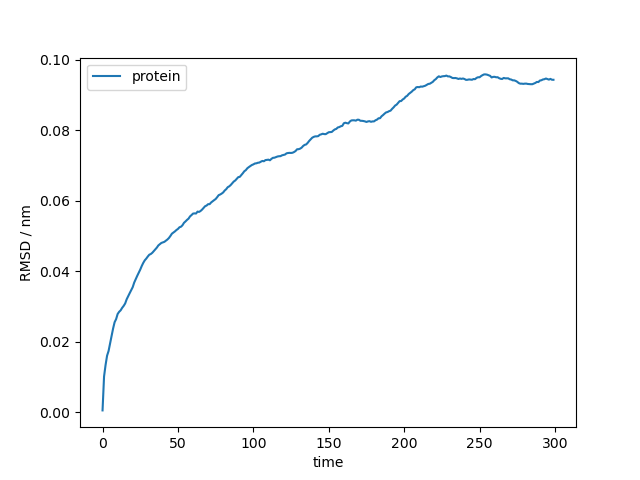

In [23]:
# make sure rmsd plot was generated
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_183946'))

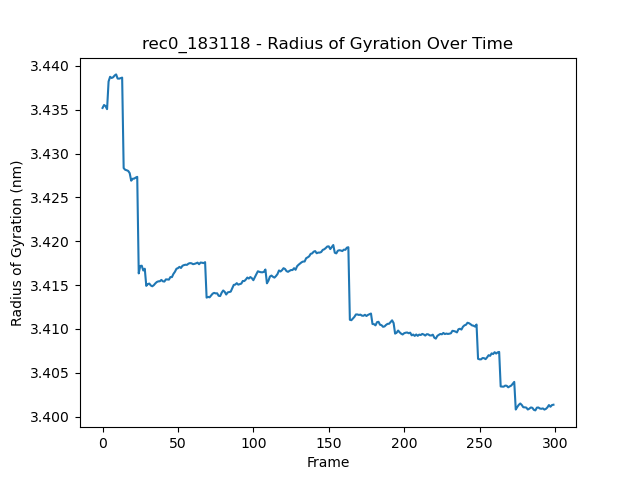

In [22]:
# make sure rgy plot was generated
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_185033'))

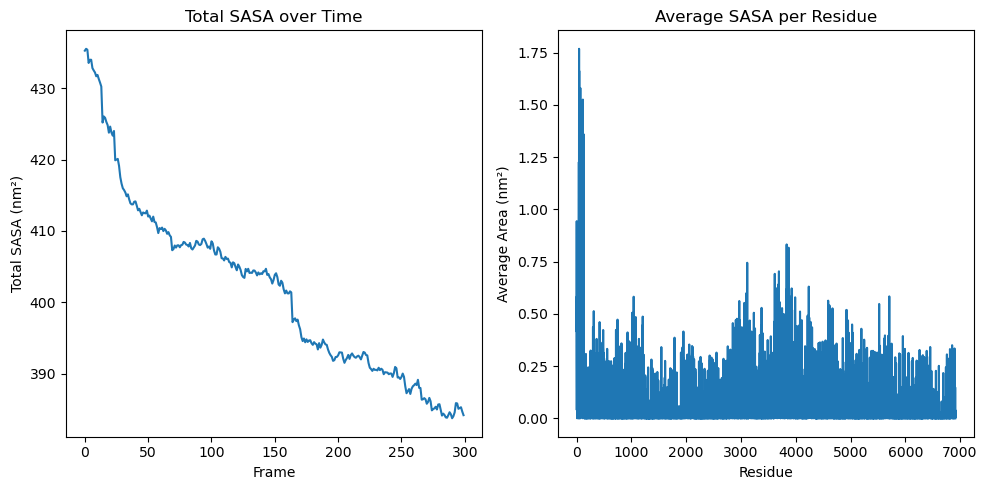

In [21]:
# make sure sasa plot was generated
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_185009'))